# Prey Predator Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 11/Mar/2020 08:02

# Prey Predator dynamics on SD and ABM

On this notebook, we'll explore and visualize how P&P behave both in an Lotka-Volterra formalism, as in an agent-based one.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
from prey_predator_sd import run
from prey_predator_abm import run

In [15]:
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f874824f310>, <cadCAD.configuration.Configuration object at 0x7f874824fed0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f874824f310>, <cadCAD.configuration.Configuration object at 0x7f874824fed0>]
Execution in 166.7s


### System Dynamics - Lotka-Volterra

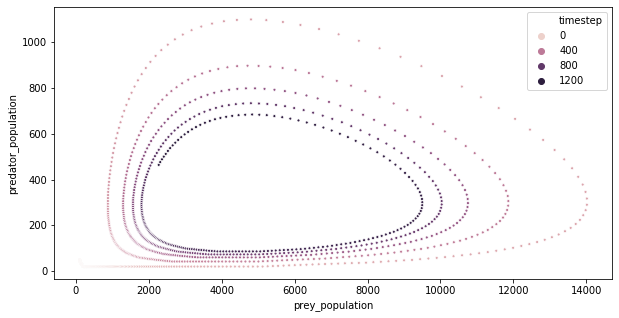

In [4]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=experiments.dataset[0],
                x='prey_population',
                y='predator_population',
                hue='timestep',
                marker='.')
plt.show()

### Agent-based modelling

In [16]:
agent_ds = experiments.dataset[1].agents
site_ds = experiments.dataset[1].sites
timesteps = experiments.dataset[1].timestep

# Get metrics
prey_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'prey']))
predator_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'predator']))

food_at_sites = site_ds.map(lambda s: s.sum())
food_at_prey = agent_ds.map(lambda s: sum([agent['food'] for agent in s.values() if agent['type'] == 'prey']))
food_at_predators = agent_ds.map(lambda s: sum([agent['food'] for agent in s.values() if agent['type'] == 'predator']))

median_site_food = site_ds.map(lambda s: np.median(s)) 
median_prey_food = agent_ds.map(lambda s: np.median([agent['food'] for agent in s.values() if agent['type'] == 'prey']))
median_predator_food = agent_ds.map(lambda s: np.median([agent['food'] for agent in s.values() if agent['type'] == 'predator']))

prey_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'prey']))
predator_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'predator']))

# Create an analysis dataset
data = (pd.DataFrame({'timestep': timesteps,
                      'prey_count': prey_count,
                      'predator_count': predator_count,
                      'food_at_sites': food_at_sites,
                      'food_at_prey': food_at_prey,
                      'food_at_predators': food_at_predators,
                      'median_site_food': median_site_food,
                      'median_prey_food': median_prey_food,
                      'median_predator_food': median_predator_food,
                      'prey_median_age': prey_median_age,
                      'predator_median_age': predator_median_age})       
       )

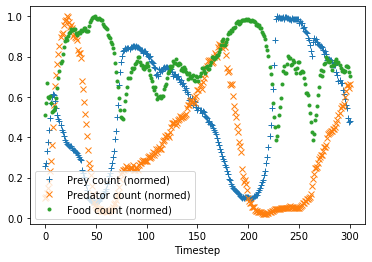

In [17]:
# Plot an time-series of it.
plt.plot(timesteps,
         prey_count / prey_count.max(),
         '+',
         color='C0',
         label='Prey count (normed)')
plt.plot(timesteps,
         predator_count / predator_count.max(),
         'x',
         color='C1',
         label='Predator count (normed)')
plt.plot(timesteps,
         food_at_sites / food_at_sites.max(),
         '.',
         color='C2', 
         label='Food count (normed)')
plt.xlabel('Timestep')
plt.legend()
plt.show()

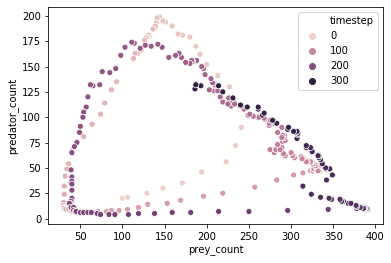

In [18]:
sns.scatterplot(data=data,
                x='prey_count',
                y='predator_count',
                hue='timestep')
plt.show()

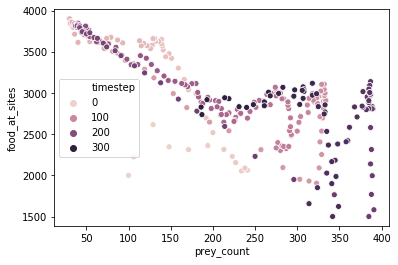

In [19]:
sns.scatterplot(data=data,
                x='prey_count',
                y='food_at_sites',
                hue='timestep')
plt.show()

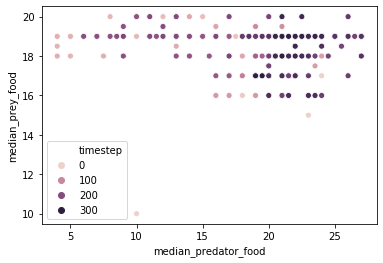

In [20]:
sns.scatterplot(data=data,
                x='median_predator_food',
                y='median_prey_food',
                hue='timestep')
plt.show()

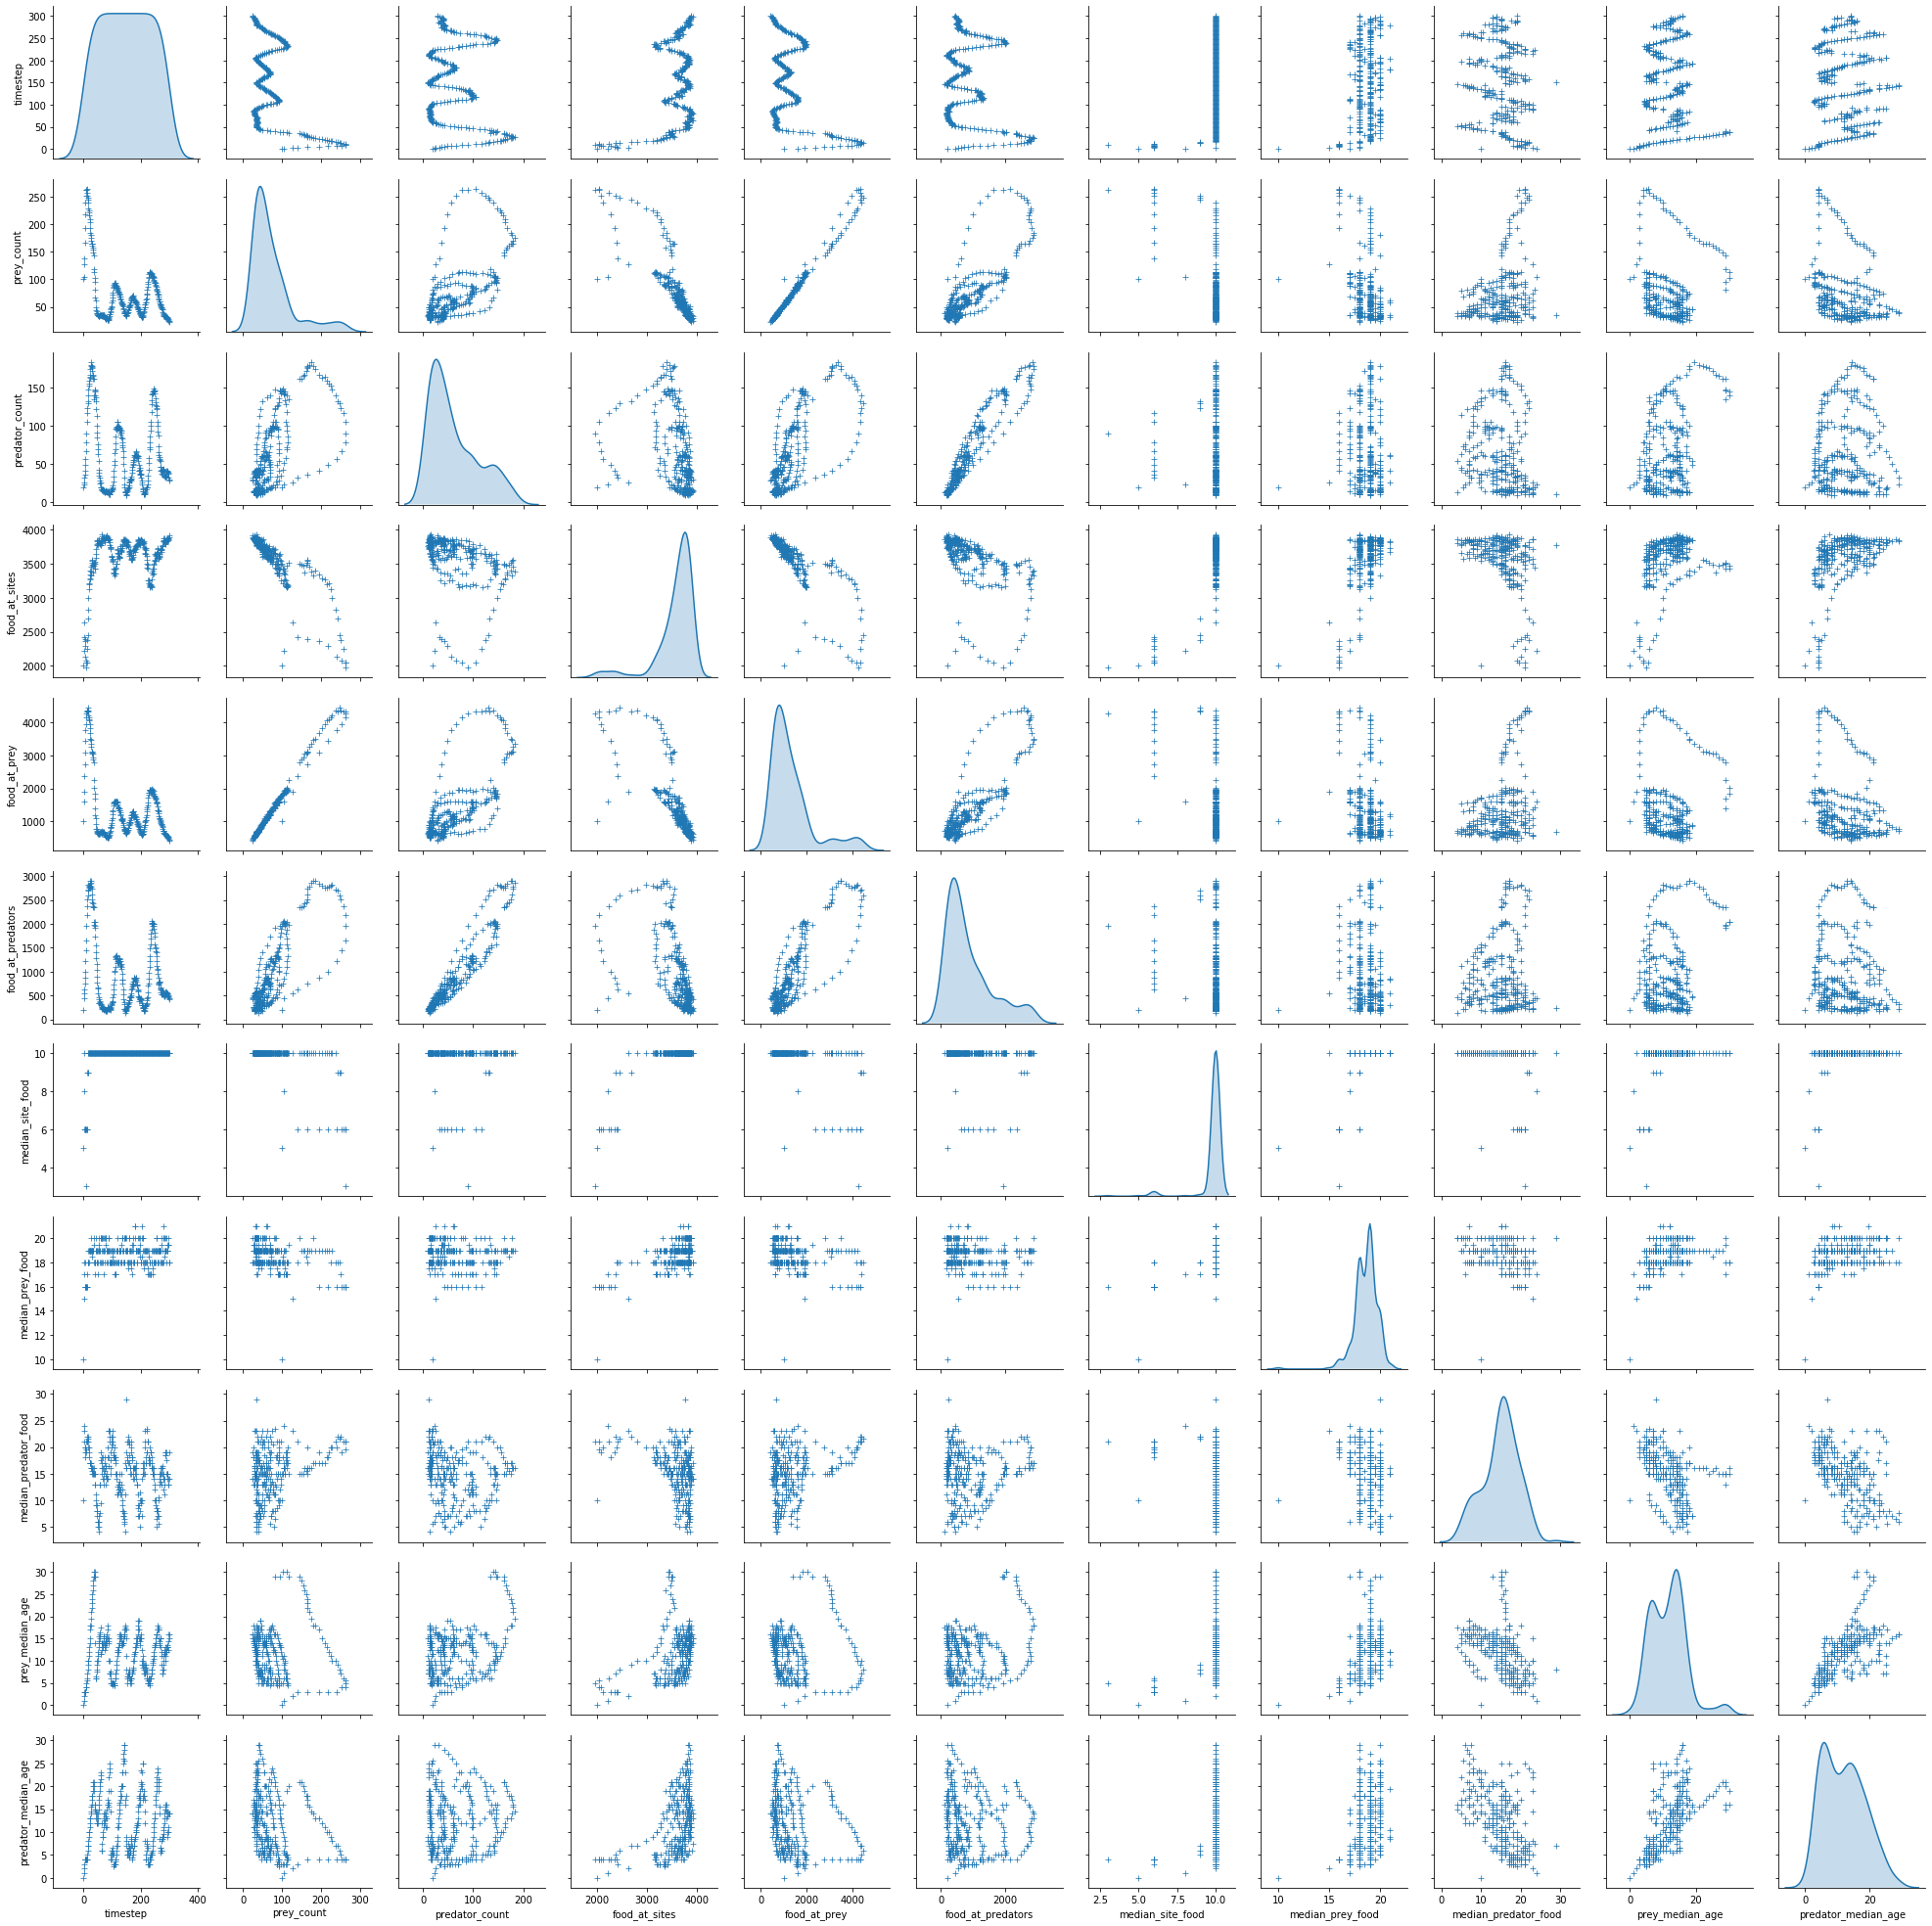

In [10]:
sns.pairplot(data=data, 
             diag_kind='kde', 
             markers='+')
plt.show()